# Introduction to Geopandas and Tidy Spatial Data

for: GEOM90042
by: Martin Tomko, 2020

In this lecture, we will finally bring our knowledge of Pandas ( and data frames) and of all the spatial data handling we learned when covering geometries ( Shapely) and Features (Fiona) together.

We will link the concept of data frames from pandas, by adding a geometry attribute ( as single one per frame). The reading of all data to GeoPandas is done through Fiona, and all the geometries are Shapely objects.

- You will learn how the data are read and created, and saved. You will understand basic wrangling operations, but you will have to disover more on your own.
- You will understand the concept of tidy data.
- You will understand basic visualization ( but you will need to discover more on your own).
- Finally, and importantly, we wil look at spatial tricks to speed up some analyses, using the concept of indices ( also refer to the Spatial Database course, if you are doing this).

In [2]:
# imports
import os
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt

# set up some dp parameters
matplotlib.rcParams['savefig.dpi'] = 300
matplotlib.rcParams["figure.dpi"] = 100

## Reading in a basic shapefile

We will read in a shapefile. And look at it.

In [3]:
melb_sa3_infile = os.path.join("..","data","SA3_GreaterMelbourne.shp")
os.path.exists(melb_sa3_infile)

True

In [4]:
# see that reading in the geopandas is very simple. 
# It opens and closes its context, so we have not to worry about
melb_sa3 = gpd.read_file(melb_sa3_infile)
melb_sa3.head()

SA3_CODE11                                           geometry
0      20601  POLYGON ((144.98054 -37.74747, 144.98055 -37.7...
1      20602  POLYGON ((145.00423 -37.75259, 145.00532 -37.7...
2      20603  POLYGON ((144.92790 -37.75262, 144.92789 -37.7...
3      20604  POLYGON ((144.90644 -37.80885, 144.90671 -37.8...
4      20605  POLYGON ((144.97656 -37.88272, 144.97582 -37.8...

In [5]:
# we can always check that the data frame is indeed geopandas
type(melb_sa3)

geopandas.geodataframe.GeoDataFrame

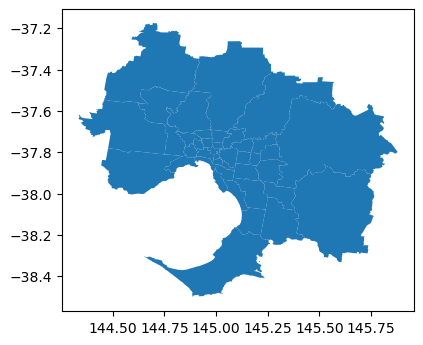

In [6]:
#import geoplot
melb_sa3.plot()

In [7]:
# We should also become aware of the bounds of the data frame, and what is the geometry column
melb_sa3.total_bounds


array([144.3336113 , -38.50298802, 145.878412  , -37.17509899])

In [9]:
# The bounds of the individuasl geometries are also accessible
melb_sa3.head().bounds

minx       miny        maxx       maxy
0  144.926768 -37.780208  144.986865 -37.732506
1  144.979240 -37.785631  145.037120 -37.750271
2  144.888945 -37.789626  144.940362 -37.734582
3  144.902701 -37.850667  144.991351 -37.775448
4  144.897093 -37.891737  145.010522 -37.820031

In [10]:
# We should always be certain of the units of our CRS
print(melb_sa3.crs)

None


In [16]:
# the CRS has not been set - because the shp misses the prj information. So we should set it up.
# Here, we know it is GDA94
gda94crs = 'epsg:4283'
melb_sa3.crs = gda94crs
print(melb_sa3.crs)

epsg:4283


In [17]:
# We may want to reproject to a planar system, for processing.
# Here, we will use GDA94/Vicgrid, epsg:3111

melb_sa3_plan = melb_sa3.to_crs("EPSG:3111")
melb_sa3_plan.head()

SA3_CODE11                                           geometry
0      20601  POLYGON ((2498285.488 2417052.924, 2498285.937...
1      20602  POLYGON ((2500372.400 2416484.707, 2500468.628...
2      20603  POLYGON ((2493646.463 2416478.472, 2493645.248...
3      20604  POLYGON ((2491761.312 2410236.203, 2491785.199...
4      20605  POLYGON ((2497937.864 2402041.736, 2497873.284...

In [18]:
# we see that the total bounds of the dataset cahnged too
melb_sa3_plan.total_bounds

array([2441188.34127279, 2333181.16307187, 2577357.47854867,
       2480526.80503551])

## Computing attributes based on geometries

We can trivially use shapely operations to compute parameters and analyses based on geometries. Note, that shapely **ONLY** operates on planar geometries. Hence why I had to reproject the geometries above!

**Note** - *this tutorial is based on current GeoPandas 0.7 - there is initial implementation of spherical methods for 0.8 in the pipeline, as of writing ( May 2020).* https://github.com/geopandas/geopandas/pull/1376

In [19]:
# Add a column with the area of each region
# the shapely methods exposed are here : https://geopandas.org/reference.html
# We also use a basic pandas function *round* to limit the numbers to two decimals
# this shows how geopandas builds on top of pandas.
melb_sa3_plan['sa3_area']=
melb_sa3_plan.head()

SA3_CODE11                                           geometry     sa3_area
0      20601  POLYGON ((2498285.488 2417052.924, 2498285.937...  20410649.97
1      20602  POLYGON ((2500372.400 2416484.707, 2500468.628...  14025548.67
2      20603  POLYGON ((2493646.463 2416478.472, 2493645.248...  18211600.27
3      20604  POLYGON ((2491761.312 2410236.203, 2491785.199...  31545461.84
4      20605  POLYGON ((2497937.864 2402041.736, 2497873.284...  25606992.62

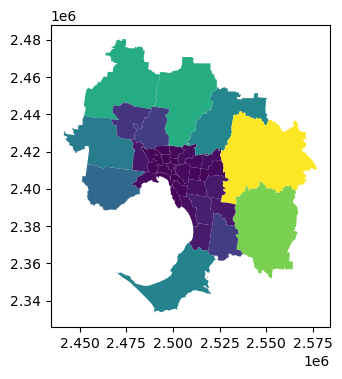

In [23]:
# We can be more sophisticated with the plotting
melb_sa3_plan.plot(column='sa3_area')

## Spatial joins

A fundamental operation in any spatial analysis -- you can join attributes to a geometry form another frame.
The important parameters are *how* (the type of join - left, right, inner, ...) and *op* (which spatial operation)



In [24]:
from shapely.geometry import Point, MultiPolygon
import random

In [25]:
# We will generate random points in the area of Melbourne
def random_points_in_polygon(number, polygon):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < number:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
            i += 1
    return points  # returns list of shapely point

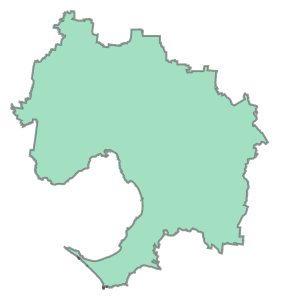

In [29]:
all_melb = melb_sa3_plan.unary_union
all_melb

In [30]:
pts = random_points_in_polygon(1000, all_melb)

In [31]:
type(pts)

list

In [32]:
gds_points = gpd.GeoSeries(pts)
gds_points.head()

0    POINT (2474014.206 2412227.416)
1    POINT (2450454.548 2431298.071)
2    POINT (2540331.997 2379529.526)
3    POINT (2545481.104 2434613.409)
4    POINT (2518523.967 2382296.177)
dtype: geometry

In [33]:
# we convert this to a GeoDataFrame
gpf_points = gpd.GeoDataFrame(geometry=gds_points)
gpf_points

geometry
0    POINT (2474014.206 2412227.416)
1    POINT (2450454.548 2431298.071)
2    POINT (2540331.997 2379529.526)
3    POINT (2545481.104 2434613.409)
4    POINT (2518523.967 2382296.177)
..                               ...
995  POINT (2474594.905 2410781.562)
996  POINT (2463623.905 2429235.335)
997  POINT (2508476.723 2402711.038)
998  POINT (2473759.737 2398332.042)
999  POINT (2508514.580 2440926.112)

[1000 rows x 1 columns]

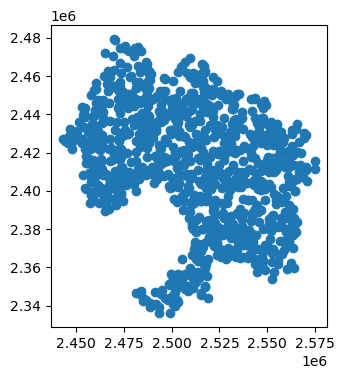

In [38]:
# Execute a spatial join to add attributes form the other data frame
gpf_points.crs = "EPSG:3111"
pts_enriched = gpd.sjoin(gpf_points,melb_sa3_plan,how="left", op='within')
pts_enriched.plot()
#gdf_points = gdf_points[gdf_points.within(gdf_polys.unary_union)]

In [36]:
pts_enriched.head()

geometry  index_right SA3_CODE11      sa3_area
0  POINT (2474014.206 2412227.416)           36      21304  6.718658e+08
1  POINT (2450454.548 2431298.071)           36      21304  6.718658e+08
2  POINT (2540331.997 2379529.526)           28      21201  1.281510e+09
3  POINT (2545481.104 2434613.409)           27      21105  1.604732e+09
4  POINT (2518523.967 2382296.177)           31      21204  1.511003e+08

Joins can be made much more efficient by first indexing the dataset. YOu can create a spatial index on the datasets as follows:


In [37]:
melb_sa3_plan.sindex
gpf_points.sindex

rtree.index.Index(bounds=[2443431.363812698, 2336019.457243697, 2574770.798421297, 2479390.8612539493], size=1000)

## What if we wanted to count the points in the polygons?

This requires counting per "group" ( region) and also some shape manipulation. We will use this example to cover a few details of tidy data here.

In [39]:
dfpivot = pd.pivot_table(pts_enriched, columns='SA3_CODE11',aggfunc={'SA3_CODE11':len})
#dfpivot.columns = dfpivot.columns.droplevel()
dfpivot.head()


SA3_CODE11  20601  20602  20603  20604  20605  20606  20701  20702  20703  \
SA3_CODE11      5      1      4      4      4      1      7      4      6   

SA3_CODE11  20801  ...  21203  21204  21205  21301  21302  21303  21304  \
SA3_CODE11      3  ...     33     19      5      7      9      5     77   

SA3_CODE11  21305  21401  21402  
SA3_CODE11     64     14     68  

[1 rows x 39 columns]

### Tidy data

Tidy data are normalized forms, and are usually known as wide format ( as above) or long format.

[https://www.jeannicholashould.com/tidy-data-in-python.html](https://www.jeannicholashould.com/tidy-data-in-python.html)


In [40]:
# we re-shape our data frame to a long format.
sa3_ptcounts= dfpivot.melt( value_name='pt_count')
sa3_ptcounts.head()

SA3_CODE11  pt_count
0      20601         5
1      20602         1
2      20603         4
3      20604         4
4      20605         4

In [41]:
# and then join this naturally to the Melbourne area data 
melb_sa3_plan.merge(sa3_ptcounts, on='SA3_CODE11')

SA3_CODE11                                           geometry  \
0       20601  POLYGON ((2498285.488 2417052.924, 2498285.937...   
1       20602  POLYGON ((2500372.400 2416484.707, 2500468.628...   
2       20603  POLYGON ((2493646.463 2416478.472, 2493645.248...   
3       20604  POLYGON ((2491761.312 2410236.203, 2491785.199...   
4       20605  POLYGON ((2497937.864 2402041.736, 2497873.284...   
5       20606  POLYGON ((2498642.187 2405857.066, 2498655.976...   
6       20701  POLYGON ((2502146.954 2407398.586, 2502167.111...   
7       20702  POLYGON ((2514151.323 2411001.583, 2514152.060...   
8       20703  POLYGON ((2514151.323 2411001.583, 2514160.349...   
9       20801  POLYGON ((2498798.871 2398228.797, 2498798.955...   
10      20802  POLYGON ((2504521.956 2396228.742, 2504401.837...   
11      20803  POLYGON ((2510184.196 2382341.043, 2510182.952...   
12      20804  POLYGON ((2506077.829 2401828.873, 2505934.264...   
13      20901  POLYGON ((2511601.990 2422273.768, 2511528.885...   
14      20902  POLYGON ((2498111.639 2422835.756, 2498111.687...   
15      20903  POLYGON ((2534912.145 2448054.161, 2534942.305...   
16      20904  POLYGON ((2496812.849 2436712.102, 2496815.866...   
17      21001  POLYGON ((2486440.386 2417054.627, 2486437.115...   
18      21002  POLYGON ((2473315.620 2480396.500, 2473526.702...   
19      21003  POLYGON ((2498114.206 2422853.832, 2498114.387...   
20      21004  POLYGON ((2469705.454 2434040.070, 2469375.208...   
21      21005  POLYGON ((2482969.043 2432613.291, 2482971.516...   
22      21101  POLYGON ((2517310.124 2401361.615, 2517310.345...   
23      21102  POLYGON ((2520448.713 2418796.420, 2520518.477...   
24      21103  POLYGON ((2526971.175 2413244.354, 2526971.036...   
25      21104  POLYGON ((2514026.844 2406277.339, 2514037.578...   
26      21105  POLYGON ((2527537.752 2420732.499, 2527507.653...   
27      21201  POLYGON ((2533084.719 2380125.217, 2533088.080...   
28      21202  POLYGON ((2520645.741 2391546.623, 2520640.893...   
29      21203  POLYGON ((2533084.719 2380125.217, 2533101.474...   
30      21204  POLYGON ((2520645.741 2391546.623, 2520639.550...   
31      21205  POLYGON ((2514129.901 2404445.905, 2514147.349...   
32      21301  POLYGON ((2479500.357 2420946.865, 2479526.560...   
33      21302  POLYGON ((2479871.545 2403673.414, 2479896.475...   
34      21303  POLYGON ((2487174.631 2414092.555, 2487210.327...   
35      21304  POLYGON ((2441600.862 2429662.358, 2441592.929...   
36      21305  POLYGON ((2452045.054 2403541.122, 2452036.886...   
37      21401  POLYGON ((2509940.423 2372307.912, 2509960.186...   
38      21402  MULTIPOLYGON (((2519270.334 2365474.138, 25198...   

        sa3_area  pt_count  
0   2.041065e+07         5  
1   1.402555e+07         1  
2   1.821160e+07         4  
3   3.154546e+07         4  
4   2.560699e+07         4  
5   1.192309e+07         1  
6   6.001318e+07         7  
7   4.866680e+07         4  
8   3.805052e+07         6  
9   3.720963e+07         3  
10  4.069875e+07         4  
11  6.986254e+07         8  
12  1.372366e+07         1  
13  6.260635e+07         6  
14  3.943802e+07         6  
15  7.516142e+08        65  
16  9.972125e+08        94  
17  4.242055e+07         1  
18  9.918474e+08        92  
19  3.037397e+07         2  
20  2.606306e+08        26  
21  2.940324e+08        33  
22  1.182085e+08        10  
23  6.655333e+07         6  
24  6.118240e+07         7  
25  2.656677e+07         2  
26  1.604732e+09       158  
27  1.281510e+09       127  
28  1.164721e+08        12  
29  2.929735e+08        33  
30  1.511003e+08        19  
31  7.948292e+07         5  
32  1.068352e+08         7  
33  6.221104e+07         9  
34  3.122332e+07         5  
35  6.718658e+08        77  
36  5.440835e+08        64  
37  1.296100e+08        14  
38  7.242449e+08        68

## Slicing by space

We can use the standard indexing means for pandas to access parts of the dataset, by attributes.
But we may want to do this by space too. Geopandas introduces the *.cx* index

In [42]:
# let's get data for a central part of the area
# the non-projected boundig box is something like
# [-37.89:-37.71,144.79:145.09]
# We need to project it - using pyproj

lower_left = (144.79,-37.89)
upper_right = (145.09,-37.71)
from pyproj import CRS,Transformer
crs_4283 = CRS.from_epsg(4283)
crs_3111 = CRS.from_epsg(3111)
# note the use of always_xy here - it is a good thing to do, as you have likely already discovered.
transformer = Transformer.from_crs(crs_4283, crs_3111,always_xy=True)
ll_proj = transformer.transform(lower_left[0],lower_left[1])
ur_proj = transformer.transform(upper_right[0],upper_right[1])
print(ll_proj, "\n",ur_proj)

(2481528.265895718, 2401213.1234726384) 
 (2507935.349086735, 2421207.344482523)


In [43]:
# min_x:max_x,min_y:max_y
melb_cbd = melb_sa3_plan.cx[ll_proj[0]:ur_proj[0],ll_proj[1]:ur_proj[1]]

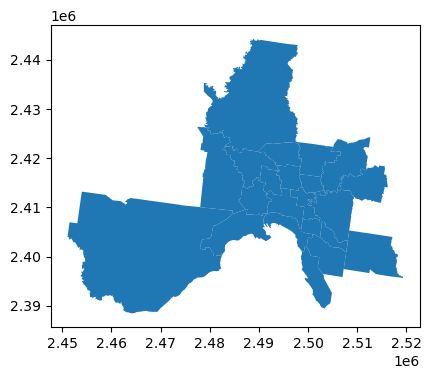

In [44]:
melb_cbd.plot()

# Basic plots

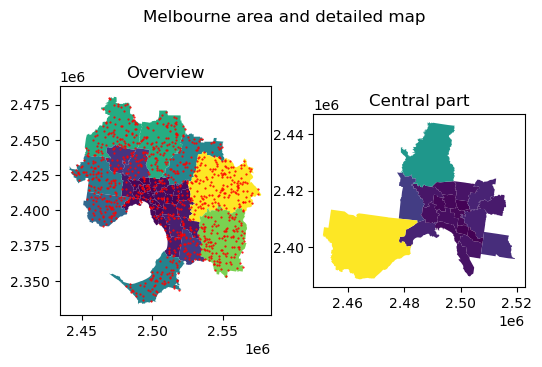

In [46]:
## Nicer plotting with matplotlib tricks
# fig sets up the figure
# axes is a funny name for the content of a figure, If we have subplots, each of them is an *ax*
# we can assign them with nicer names.
fig, (left_ax,right_ax) = plt.subplots(ncols=2) 
fig.suptitle('Melbourne area and detailed map')
melb_sa3_plan.plot(ax=left_ax,column='sa3_area')
# you can push multiple plots to the same ax, tto overplot
gpf_points.plot(ax=left_ax, markersize=0.3, c="red")
left_ax.set_title("Overview")
melb_cbd.plot(ax=right_ax,column='sa3_area')
right_ax.set_title("Central part")
plt.savefig('figs/melbourne.png', dpi=300)



### Colors matter: as a spatial analyst, you must be in contorl of your colours, and the apperance of the data:

In spatial, we like to use ColorBrewer, to select paletes. These are available also in Matplotlib:
[https://colorbrewer2.org/#type=sequential&scheme=BuGn&n=3](https://colorbrewer2.org/#type=sequential&scheme=BuGn&n=3)

YOu can also explore Palettable, if you feel like it: [https://jiffyclub.github.io/palettable/](https://jiffyclub.github.io/palettable/)

Here is what is built in in Matplotlib

[https://matplotlib.org/3.2.1/api/pyplot_summary.html](https://matplotlib.org/3.2.1/api/pyplot_summary.html)

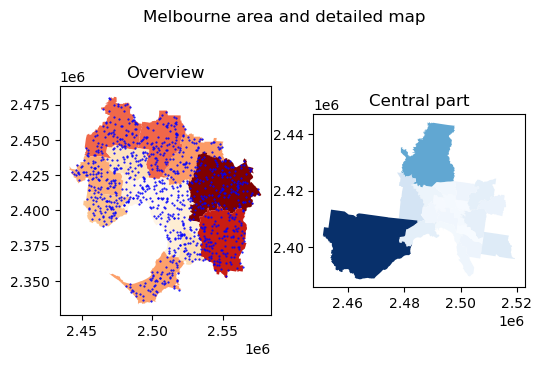

In [48]:

## Nicer plotting with matplotlib tricks
# fig sets up the figure
# axes is a funny name for the content of a figure, If we have subplots, each of them is an *ax*
# we can assign them with nicer names.
fig, (left_ax,right_ax) = plt.subplots(ncols=2) 
fig.suptitle('Melbourne area and detailed map')
melb_sa3_plan.plot(ax=left_ax,column='sa3_area',cmap='OrRd')
# you can push multiple plots to the same ax, tto overplot
gpf_points.plot(ax=left_ax, markersize=0.3, c="blue")
left_ax.set_title("Overview")
melb_cbd.plot(ax=right_ax,column='sa3_area',cmap='Blues')
right_ax.set_title("Central part")
plt.savefig('figs/melbourne_nicer.png', dpi=300)


# Challenge:

Explore the mapclassify measn to align colour ramps, and generate scientifically better plots:
https://geopandas.org/mapping.html
https://github.com/pysal/mapclassify

Or you can achieve the same by applying a colour ramp on pre-classified data.

You should also explore additonal means to analyse the dataframes, and combine statistical plots with the map plots.

You can also explore dynamic plotting and others.
You should also explore the geocoding abilities of geopandas (see the documentation), but we may cover these a bit more

## Challenge 2:
Explore saptial data analysis of your data, in more depth:
- PySAL, the library for statistical spatial analysis [https://pysal.org/](https://pysal.org/)
- OSMnx, the library for nice plotting and analsyis of street networks [https://osmnx.readthedocs.io/en/stable/](https://osmnx.readthedocs.io/en/stable/)

And much more.

        